In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

## Latent Guard's accuracy across score bins

In [2]:
threshold = 4.47

def assign_bin(score, threshold=4.47):
    diff = np.absolute(score - threshold)
    if np.absolute(score - threshold):
        if diff <= 0.1:
            return '0.1'
        elif diff <= 0.5:
            return '0.5'
        elif diff <= 1:
            return '1'
        elif diff <= 1.5:
            return '1.5'
        elif diff <= 2:
            return '2'
        elif diff <= 3:
            return '3'
        elif diff <= 4:
            return '4'
        elif diff <= 5:
            return '5'
        else:
            return '>5'

In [3]:
settings = [
    'id_explicit', 'id_synonym', 'id_adversarial',
    'ood_explicit', 'ood_synonym', 'ood_adversarial'
]

results_df = pd.DataFrame(columns = ['prediction', 'target', 'prediction_binary', 'setting'])

for setting in settings:
    path = f'../multistage_pipeline/predictions/test/{setting}.csv'
    df = pd.read_csv(path)
    df = df[['prediction', 'target', 'prediction_binary']]
    df['setting'] = setting
    results_df = pd.concat([results_df, df], ignore_index=True)

results_df['delta_bin'] = results_df['prediction'].apply(lambda x: assign_bin(x))


In [4]:
results_df

,prediction,target,prediction_binary,setting,delta_bin
0,14.423199,1,1,id_explicit,>5
1,15.908711,1,1,id_explicit,>5
2,15.813921,1,1,id_explicit,>5
3,14.242638,1,1,id_explicit,>5
4,15.515493,1,1,id_explicit,>5
...,...,...,...,...,...
83099,-0.304662,0,0,ood_adversarial,5
83100,3.015895,0,0,ood_adversarial,1.5
83101,2.783549,0,0,ood_adversarial,2
83102,-1.016147,0,0,ood_adversarial,>5


In [5]:
accuracy_by_bin_df = pd.DataFrame(columns=['delta_bin', 'accuracy', 'count'])
for delta_bin in results_df['delta_bin'].unique():
    df = results_df[results_df['delta_bin'] == delta_bin]
    y_true = df['target'].astype(int)
    y_pred = df['prediction_binary'].astype(int)
    acc = metrics.accuracy_score(y_true, y_pred)
    count = len(y_true)
    accuracy_by_bin_df = pd.concat([accuracy_by_bin_df, pd.DataFrame([{
        "delta_bin": delta_bin,
        "accuracy": acc,
        "count": count
    }])], ignore_index=True)
    
custom_order = ['0.1', '0.5', '1', '1.5', '2', '3', '4', '5', '>5']
accuracy_by_bin_df['delta_bin'] = pd.Categorical(accuracy_by_bin_df['delta_bin'], categories = custom_order, ordered=True)
accuracy_by_bin_df = accuracy_by_bin_df.sort_values('delta_bin')
accuracy_by_bin_df['cumulative_count'] = accuracy_by_bin_df['count'].cumsum()
accuracy_by_bin_df

,delta_bin,accuracy,count,cumulative_count
8,0.1,0.455178,1149,1149
3,0.5,0.537581,4018,5167
6,1,0.601475,5287,10454
1,1.5,0.676738,5494,15948
5,2,0.741419,5681,21629
7,3,0.825018,12207,33836
2,4,0.886448,12884,46720
4,5,0.933479,11425,58145
0,>5,0.967387,24959,83104


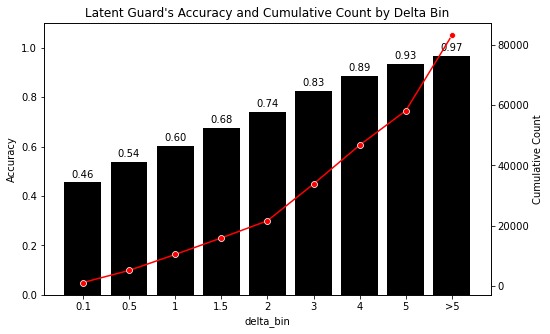

In [6]:
# Make figure
fig, ax1 = plt.subplots(figsize=(8,5))

# --- Barplot on primary y-axis (left)
sns.barplot(data=accuracy_by_bin_df, x='delta_bin', y='accuracy', color="black", ax=ax1)

# Show value on each bar
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10, color='black',
                xytext=(0, 3),
                textcoords='offset points')

ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1.1)

# --- Lineplot on secondary y-axis (right)
ax2 = ax1.twinx()
sns.lineplot(data=accuracy_by_bin_df, x='delta_bin', y='cumulative_count', marker='o', color='red', ax=ax2)

ax2.set_ylabel('Cumulative Count')

# --- Title
plt.title("Latent Guard's Accuracy and Cumulative Count by Delta Bin")

plt.show()


## Pre Latent Guard: Word level filtering

In [7]:
settings = [
    'id_explicit', 'id_synonym', 'id_adversarial',
    'ood_explicit', 'ood_synonym', 'ood_adversarial',
    'unsafe_diffusion', 'I2P'
]

prelatentguard_df = pd.DataFrame(columns = ['prediction', 'target', 'prediction_binary', 'prediction_pre_latentguard', 'word_level_blacklist_flag', 'setting'])

for setting in settings:
    path = f'../multistage_pipeline/predictions/test/{setting}.csv'
    df = pd.read_csv(path)
    df = df[['prediction', 'target', 'prediction_binary', 'prediction_pre_latentguard', 'word_level_blacklist_flag']]
    df['setting'] = setting
    prelatentguard_df = pd.concat([prelatentguard_df, df], ignore_index=True)



In [8]:
prelatentguard_result_df = pd.DataFrame(columns = ['setting', 'LG_accuracy', 'LG_w/_pre-filtering_accuracy', 'LG_w/_pre-filtering_percentage'])
for setting in settings:
    df = prelatentguard_df[prelatentguard_df['setting'] == setting]
    y_true = df['target'].astype(int)
    y_pred = df['prediction_binary'].astype(int)
    y_pred_pre = df['prediction_pre_latentguard'].astype(int)
    acc = metrics.accuracy_score(y_true, y_pred)
    acc_pre = metrics.accuracy_score(y_true, y_pred_pre)
    count = len(df)
    count_pre = len(df[df['word_level_blacklist_flag']==1])
    percentage = round(count_pre/ count * 100)
    prelatentguard_result_df = pd.concat([prelatentguard_result_df, pd.DataFrame([{
        "setting": setting,
        "LG_accuracy": acc,
        "LG_w/_pre-filtering_accuracy": acc_pre,
        "LG_w/_pre-filtering_percentage": percentage
    }])], ignore_index=True)

In [9]:
prelatentguard_result_df

,setting,LG_accuracy,LG_w/_pre-filtering_accuracy,LG_w/_pre-filtering_percentage
0,id_explicit,0.868147,0.840308,26
1,id_synonym,0.828143,0.816229,28
2,id_adversarial,0.828705,0.822514,28
3,ood_explicit,0.867596,0.840372,10
4,ood_synonym,0.824182,0.800993,10
5,ood_adversarial,0.819528,0.799674,10
6,unsafe_diffusion,0.723152,0.716179,15
7,I2P,0.573783,0.571018,6
